# Self-Corrective RAG using LangGraph

In [1]:
import re
from typing import Annotated, Iterator, Literal, TypedDict

from langchain import hub
from langchain_community.vectorstores import Chroma
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import BaseMessage, AIMessage, convert_to_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.retrievers import BaseRetriever
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, StateGraph, add_messages
from langgraph.checkpoint.memory import MemorySaver

C:\Users\Anastasia\sber-reports-rag\venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


## Get retriever

In [2]:
from langchain.text_splitter import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

C:\Users\Anastasia\sber-reports-rag\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Функция извлечения элементов из pdf-файла
def extract_pdf_elements(path, fname):
    """
    Функция для извлечения различных элементов из PDF-файла, таких как изображения, таблицы,
    и текста. Также осуществляется разбиение текста на части (чанки) для дальнейшей обработки.

    Аргументы:
    path: Строка, содержащая путь к директории, в которую будут сохранены извлеченные изображения.
    fname: Строка, содержащая имя PDF-файла, который необходимо обработать.

    Возвращает:
    Список объектов типа `unstructured.documents.elements`, представляющих извлеченные из PDF элементы.
    """
    return partition_pdf(
        filename=path + fname,          # Путь к файлу, который нужно обработать
        extract_images_in_pdf=True,     # Указание на то, что из PDF нужно извлечь изображения
        infer_table_structure=True,     # Автоматическое определение структуры таблиц в документе
        strategy="hi_res", # Ваш код здесь,   # Стратегия разбиения текста на части
        max_characters=1024,# Ваш код здесь,            # Максимальное количество символов в одном чанке текста
        new_after_n_chars=1024, # Ваш код здесь,         # Число символов, после которого начинается новый чанк текста
        combine_text_under_n_chars=512,# Ваш код здесь,# Минимальное количество символов, при котором чанки объединяются
        image_output_dir_path=path,     # Путь, куда будут сохраняться извлеченные изображения
    )

# Указываем путь до директории, где находится PDF-файл
fpath = "../data/raw/"
# Указываем имя PDF-файла, который нужно обработать
fname = "Сбер 2023-1-20.pdf"

# Извлекаем элементы из PDF-файла с помощью функции extract_pdf_elements
raw_pdf_elements = extract_pdf_elements(fpath, fname)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Функция категоризации элементов
def categorize_elements(raw_pdf_elements):
    """
    Функция для категоризации извлеченных элементов из PDF-файла.
    Элементы делятся на текстовые элементы и таблицы.

    Аргументы:
    raw_pdf_elements: Список объектов типа `unstructured.documents.elements`,
                      представляющих извлеченные из PDF элементы.

    Возвращает:
    Два списка: texts (текстовые элементы) и tables (таблицы).
    """
    tables = []  # Список для хранения элементов типа "таблица"
    texts = []   # Список для хранения текстовых элементов
    for element in raw_pdf_elements:
        # Проверка типа элемента. Если элемент является таблицей, добавляем его в список таблиц
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        # Если элемент является композитным текстовым элементом, добавляем его в список текстов
        elif ("unstructured.documents.elements.Text" in str(type(element))
        or "unstructured.documents.elements.Title" in str(type(element))
        or "unstructured.documents.elements.NarrativeText" in str(type(element))
        or "unstructured.documents.elements.ListItem" in str(type(element))): 
            texts.append(str(element))
        elif "unstructured.documents.elements.Header" in str(type(element)):
            texts.append("## " + str(element))
    return texts, tables  # Возвращаем списки с текстами и таблицами

In [5]:
# Категоризируем извлеченные элементы на текстовые и табличные с помощью функции categorize_elements
texts, tables = categorize_elements(raw_pdf_elements)

# Создаем объект CharacterTextSplitter для разбиения текста на части (чанки)
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, # Максимальный размер чанка в символах
    chunk_overlap=0 # Количество перекрывающихся символов между чанками
)

# Объединяем все текстовые элементы в одну строку
joined_texts = " ".join(texts)

In [7]:
# Разбиваем объединенный текст на чанки, используя созданный CharacterTextSplitter
texts_4k_token = text_splitter.split_text(joined_texts)

In [13]:
import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass.getpass("openai: ")
os.environ["TAVILY_API_KEY"] = getpass.getpass("tavily: ")

openai:  ········
tavily:  ········


In [14]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# Функция для суммаризации текста и таблиц
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Функция для создания суммаризации текста и таблиц с использованием модели GPT.

    Аргументы:
    texts: Список строк (тексты), которые нужно суммировать.
    tables: Список строк (таблицы), которые нужно суммировать.
    summarize_texts: Булев флаг, указывающий, нужно ли суммировать текстовые элементы.

    Возвращает:
    Два списка: text_summaries (суммаризации текстов) и table_summaries (суммаризации таблиц).
    """

    # Шаблон для запроса к модели. Задача ассистента - создать оптимизированное описание для поиска.
    prompt_text = """ Суммаризируй кратко следующий элемент {element}.
    Сохрани ключевую информацию. Ответ должен содержать 2 предложения."""

    # Создаем шаблон запроса на основе строки с шаблоном
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Создаем модель для генерации суммаризаций. Устанавливаем температуру 0 для детерминированных ответов.
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini")# Ваш код здесь)

    # Определяем цепочку обработки запросов: сначала шаблон запроса, затем модель, затем парсер выходных данных
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    text_summaries = []  # Список для хранения суммаризаций текстов
    table_summaries = []  # Список для хранения суммаризаций таблиц

    # Если есть текстовые элементы и требуется их суммирование
    if texts and summarize_texts:
        # Выполняем параллельное суммирование текстов
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 10})# Ваш код здесь})
    elif texts:
        # Если суммирование не требуется, просто передаем исходные тексты
        text_summaries = texts

    # Если есть таблицы, выполняем их суммирование
    if tables:
        # Выполняем параллельное суммирование таблиц
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 10})# Ваш код здесь})

    return text_summaries, table_summaries  # Возвращаем результаты суммаризации

# Вызываем функцию для суммаризации текстов и таблиц, указывая, что нужно суммировать тексты
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [15]:
import base64
import os

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI


# Функция кодирования изображения в формат base64
def encode_image(image_path):
    """
    Функция для кодирования изображения в формат base64.

    Аргументы:
    image_path: Строка, путь к изображению, которое нужно закодировать.

    Возвращает:
    Закодированное в формате base64 изображение в виде строки.
    """
    with open(image_path, "rb") as image_file:
        # Читаем файл изображения в бинарном режиме и кодируем в base64
        return base64.b64encode(image_file.read()).decode("utf-8")


# Функция для суммаризации изображения с использованием модели GPT
def image_summarize(img_base64, prompt):
    """
    Функция для получения суммаризации изображения с использованием GPT модели.

    Аргументы:
    img_base64: Строка, изображение закодированное в формате base64.
    prompt: Строка, запрос для модели GPT, содержащий инструкцию для суммаризации изображения.

    Возвращает:
    Суммаризация изображения, возвращенная моделью GPT.
    """
    # Создаем объект модели GPT с заданными параметрами
    chat = ChatOpenAI(model="gpt-4o-mini", max_tokens=400)# Ваш код здесь, max_tokens=# Ваш код здесь)

    # Отправляем запрос к модели GPT
    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},  # Запрос для модели
                    {
                        "type": "image_url",  # Тип содержимого - изображение
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},  # Изображение в формате base64
                    },
                ]
            )
        ]
    )
    # Возвращаем содержимое ответа от модели
    return msg.content


def generate_img_summaries(path):
    """
    Функция для генерации суммаризаций изображений из указанной директории.

    Аргументы:
    path: Строка, путь к директории с изображениями формата .jpg.

    Возвращает:
    Два списка:
    - img_base64_list: Список закодированных изображений в формате base64.
    - image_summaries: Список суммаризаций для каждого изображения.
    """
    img_base64_list = []  # Список для хранения закодированных изображений
    image_summaries = []  # Список для хранения суммаризаций изображений

    # Запрос для модели GPT
    prompt = """Опиши ключевую информацию, которая представлена на изображении. Описание должно быть конкретным и точным, а также содержать 2-3 предложения. Обрати особое внимание на графики, диаграммы или визуальные элементы, которые можно проанализировать."""

    # Обрабатываем все файлы в указанной директории
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):  # Проверяем, что файл имеет расширение .jpg
            img_path = os.path.join(path, img_file)  # Полный путь к изображению
            base64_image = encode_image(img_path)  # Кодируем изображение в base64
            img_base64_list.append(base64_image)  # Добавляем закодированное изображение в список
            image_summaries.append(image_summarize(base64_image, prompt))  # Получаем суммаризацию изображения

    return img_base64_list, image_summaries  # Возвращаем результаты


# Вызываем функцию для генерации суммаризаций изображений
img_base64_list, image_summaries = generate_img_summaries("figures/")

In [16]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [17]:
embeddings = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")

In [18]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
# from langchain_openai import OpenAIEmbeddings


# Функция создания многофакторного ритривера для базы данных
def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Функция для создания ретривера, который может извлекать данные из разных источников (тексты, таблицы, изображения).

    Аргументы:
    vectorstore: Векторное хранилище для хранения векторных представлений документов.
    text_summaries: Список суммаризаций текстовых элементов.
    texts: Список исходных текстов.
    table_summaries: Список суммаризаций таблиц.
    tables: Список исходных таблиц.
    image_summaries: Список суммаризаций изображений.
    images: Список изображений в формате base64.

    Возвращает:
    Созданный ретривер, который может извлекать данные из различных источников.
    """

    # Создаем хранилище для метаданных документов в памяти
    store = InMemoryStore()
    id_key = "doc_id"  # Ключ для идентификации документов в хранилище

    # Создаем многофакторный ритривер
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Функция добавления документов в ритривер
    def add_documents(retriever, doc_summaries, doc_contents):
        """
        Функция для добавления документов и их метаданных в ритривер.

        Аргументы:
        retriever: Ретривер, в который будут добавляться документы.
        doc_summaries: Список суммаризаций документов.
        doc_contents: Список исходных содержимых документов.
        """
        # Генерируем уникальные идентификаторы для каждого документа
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]

        # Создаем документы для векторного хранилища из суммаризаций
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]

        # Добавляем документы в векторное хранилище
        retriever.vectorstore.add_documents(summary_docs)

        # Добавляем метаданные документов в хранилище
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Добавляем суммаризации текстов и таблиц, если они присутствуют
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever  # Возвращаем созданный ритривер


# Создаем векторное хранилище для хранения векторных представлений документов
vectorstore = Chroma(
    collection_name="mm_rag_sber",  # Название коллекции
    embedding_function=embeddings  # Функция для создания векторных представлений
)

# Создаем ретривер, добавляя суммаризации текстов, таблиц и изображений
retriever = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_6352\2476423399.py:78: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [19]:
tavily_search_tool = TavilySearchResults(max_results=3)

In [20]:
llm = ChatOpenAI(model="gpt-4o-mini")

## Graph State

In [21]:
class GraphState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    question: str
    documents: list[Document]
    candidate_answer: str
    retries: int
    web_fallback: bool


class GraphConfig(TypedDict):
    max_retries: int

In [22]:
MAX_RETRIES = 3
VERBOSE = True

In [23]:
def document_search(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if VERBOSE:
        print("---RETRIEVE---")

    question = convert_to_messages(state["messages"])[-1].content

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question, "web_fallback": True}

In [25]:
RAG_PROMPT: ChatPromptTemplate = ChatPromptTemplate.from_template("""Вы являетесь помощником при выполнении заданий по поиску ответов на вопросы. Используйте приведенные ниже фрагменты из извлеченного контекста, чтобы ответить на вопрос. Если вы не знаете ответа, просто скажите, что вы не знаете. Используйте максимум три предложения и старайтесь, чтобы ответ был кратким.

Вопрос: {question} 

Контекст: {context} 

Ответ:""")


def generate(state: GraphState):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if VERBOSE:
        print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    retries = state["retries"] if state.get("retries") is not None else -1

    rag_chain = RAG_PROMPT | llm | StrOutputParser()
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"retries": retries + 1, "candidate_answer": generation}

## Query rewriting

In [29]:
QUERY_REWRITER_SYSTEM = (
"""
Вы - переписчик вопросов, который преобразует исходный вопрос в улучшенную версию, оптимизированную для поиска в векторном хранилище.
Посмотрите на исходные данные и попытайтесь разобраться в лежащем в их основе семантическом замысле / значении.
"""
)

QUERY_REWRITER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", QUERY_REWRITER_SYSTEM),
        (
            "human",
            "Вот исходный вопрос: \n\n {question} \n Сформулируйте улучшенный вопрос.",
        ),
    ]
)

def transform_query(state: GraphState):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    if VERBOSE:
        print("---TRANSFORM QUERY---")

    question = state["question"]

    # Re-write question
    query_rewriter = QUERY_REWRITER_PROMPT | llm | StrOutputParser()
    better_question = query_rewriter.invoke({"question": question})
    return {"question": better_question}

## Web search

In [30]:
def web_search(state: GraphState):
    if VERBOSE:
        print("---RUNNING WEB SEARCH---")

    question = state["question"]
    documents = state["documents"]
    search_results = tavily_search_tool.invoke(question)
    search_content = "\n".join([d["content"] for d in search_results])
    documents.append(Document(page_content=search_content, metadata={"source": "websearch"}))
    return {"documents": documents, "web_fallback": False}

## Final response

In [31]:
def finalize_response(state: GraphState):
    if VERBOSE:
        print("---FINALIZING THE RESPONSE---")

    return {"messages": [AIMessage(content=state["candidate_answer"])]}

In [33]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Ответ основан на фактах: 'да' или 'нет'"
    )


HALLUCINATION_GRADER_SYSTEM = (
"""
Вы - выпускник, оценивающий, основывается ли ответы LLM на наборе извлеченных фактов.
Поставьте двоичную оценку "да" или "нет", где "да" означает, что ответ основан на наборе фактов или подтверждается ими.
"""
)

HALLUCINATION_GRADER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", HALLUCINATION_GRADER_SYSTEM),
        ("human", "Набор фактов: \n\n {documents} \n\n Ответ LLM: {generation}"),
    ]
)


class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Ответ на вопрос - 'да' или 'нет'."
    )


ANSWER_GRADER_SYSTEM = (
"""
Вы - эксперт, оценивающий, отвечает ли ответ LLM на вопрос или разрешает его.
Поставьте двоичную оценку "да" или "нет", где "да" означает, что ответ разрешает вопрос.
"""
)

ANSWER_GRADER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", ANSWER_GRADER_SYSTEM),
        ("human", "Вопрос пользователя: \n\n {question} \n\n Ответ LLM: {generation}"),
    ]
)

In [34]:
def grade_generation_v_documents_and_question(state: GraphState, config) -> Literal["generate", "transform_query", "web_search", "finalize_response"]:
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    question = state["question"]
    documents = state["documents"]
    generation = state["candidate_answer"]
    web_fallback = state["web_fallback"]
    retries = state["retries"] if state.get("retries") is not None else -1
    max_retries = config.get("configurable", {}).get("max_retries", MAX_RETRIES)

    # this means we've already gone through web fallback and can return to the user
    if not web_fallback:
        return "finalize_response"

    if VERBOSE:
        print("---CHECK HALLUCINATIONS---")

    hallucination_grader = HALLUCINATION_GRADER_PROMPT | llm.with_structured_output(GradeHallucinations)
    hallucination_grade: GradeHallucinations = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )

    # Check hallucination
    if hallucination_grade.binary_score == "no":
        if VERBOSE: print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "generate" if retries < max_retries else "web_search"

    if VERBOSE:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION vs QUESTION---")

    # Check question-answering
    answer_grader = ANSWER_GRADER_PROMPT | llm.with_structured_output(GradeAnswer)
    answer_grade: GradeAnswer = answer_grader.invoke({"question": question, "generation": generation})
    if answer_grade.binary_score == "yes":
        if VERBOSE: print("---DECISION: GENERATION ADDRESSES QUESTION---")
        return "finalize_response"
    else:
        if VERBOSE: print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        return "transform_query" if retries < max_retries else "web_search"

## Graph

In [35]:
workflow = StateGraph(GraphState, config_schema=GraphConfig)

# Define the nodes
workflow.add_node("document_search", document_search)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)
workflow.add_node("finalize_response", finalize_response)

# Build graph
workflow.set_entry_point("document_search")
workflow.add_edge("document_search", "generate")
workflow.add_edge("transform_query", "document_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("finalize_response", END)

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question
)

# Compile
graph = workflow.compile()

In [36]:
from IPython.display import Image, display


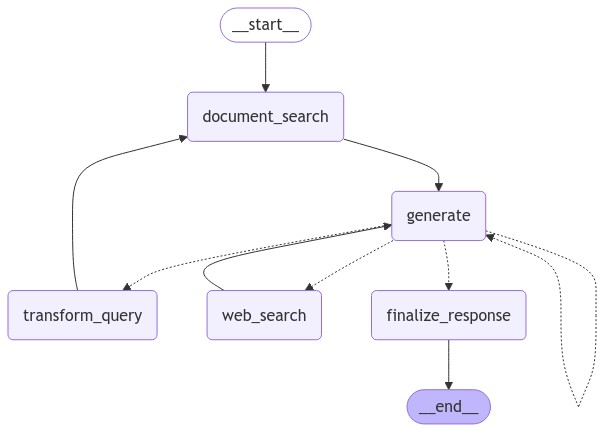

In [37]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
VERBOSE = False
inputs = {"messages": [("human", "Как сбер адаптировался к новым условиям?")]}
for output in graph.stream(inputs):
    print(output)
    print("\n---\n")